In [1]:
from collections import defaultdict
from itertools import product
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

data_folder = 'data/PsychAD_freeze2_personalized_grpahs/processed/'

In [2]:
style='white'
sns.set(style=style)
plt.rcParams.update({'font.weight': 'normal',
                     'font.size': 18,
                     'axes.titlesize': 'large',
                     'axes.labelsize': 'large',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small'})

# Functions

In [3]:
# Analyzing functions
def detect_changing_edges(edgelists):
    # Get binary edges
    binary_edgelists = {k: np.array(v)[:, :2] for k, v in edgelists.items() if len(v) > 0}

    # Filter to uniquely appearing edges (per stage)
    print('Detecting Appearing Edges...')
    binary_unique_edgelists = defaultdict(list)
    for k0, graph0 in binary_edgelists.items():
        print(f'Braak: {k0}', end='')
        num_edges = 0
        for edge in graph0:
            for k1, graph1 in binary_edgelists.items():
                if k1 >= k0:
                    continue
                if edge in graph1:
                    break
            else:  # Only if for loop completes
                binary_unique_edgelists[k0].append(edge)
                num_edges += 1
        print(f' ({num_edges})')
    binary_unique_edgelists = {k: np.stack(v) for k, v in binary_unique_edgelists.items()}

    print()
    # Filter to uniquely disappearing edges (per stage)
    print('Detecting Vanishing Edges...')
    binary_unique_edgelists_rev = defaultdict(list)
    for k0, graph0 in binary_edgelists.items():
        print(f'Braak: {k0}', end='')
        num_edges = 0
        for edge in graph0:
            for k1, graph1 in binary_edgelists.items():
                if k1 <= k0:
                    continue
                if edge in graph1:
                    break
            else:  # Only if for loop completes
                binary_unique_edgelists_rev[k0].append(edge)
                num_edges += 1
        print(f' ({num_edges})')
    binary_unique_edgelists_rev = {k: np.stack(v) for k, v in binary_unique_edgelists_rev.items()}
    
    return binary_unique_edgelists, binary_unique_edgelists_rev

def print_edges(edgelists):
    for i, (k, v) in enumerate(edgelists.items()):
        if i != 0:
            print()
        print(f'Braak: {k}')
        print('Top TFs: ', end='')
        genes, counts = np.unique(v[:, 0], return_counts=True)
        for gene in genes[np.argsort(-counts)][:20]:
            print(f' {gene}', end='')
        print()
        print('Top TGs: ', end='')
        genes, counts = np.unique(v[:, 1], return_counts=True)
        for gene in genes[np.argsort(-counts)][:20]:
            print(f' {gene}', end='')
        print()

def analyze_braak(prefix, suffix):
    edgelists = {}
    for stage in range(7):
        edgelists[stage] = pd.read_csv(prefix + f'{stage:.1f}' + suffix, index_col=0)
    bue, buer = detect_changing_edges(edgelists)
    print('\n' + 30*'-' + '\n')
    print('Appearing Edges...')
    print_edges(bue)
    print('\n' + 30*'-' + '\n')
    print('Vanishing Edges...')
    print_edges(buer)
    
    return edgelists, bue, buer

In [4]:
# Plotting functions
def format_dic(counts_dic):
    # Get all genes
    genes = []
    for k, v in counts_dic.items():
        genes += list(v[0])
    genes = np.unique(genes)

    # Format values
    genes_over_braak = defaultdict(lambda: [])
    for k, v in counts_dic.items():
        for gene in genes:
            count = v[1][np.argwhere(v[0] == gene)]
            if len(count) > 0:
                count = count[0][0]
            else:
                count = 0
            genes_over_braak[gene].append(count)
    genes_over_braak = dict(genes_over_braak)
    
    return genes_over_braak

def get_counts(edgelists):
    tf_counts = {}
    tg_counts = {}
    for k, v in edgelists.items():
        tf_counts[k] = np.unique(v['TF'], return_counts=True)  # val, count
        tg_counts[k] = np.unique(v['TG'], return_counts=True)
    tf_counts = format_dic(tf_counts)
    tg_counts = format_dic(tg_counts)
    
    return tf_counts, tg_counts

def plot_counts(counts, title='Counts by Braak Stage', ylabel='Counts', max_zero_values=0):
    for k, v in counts.items():
        # Highlight if popular
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][math.floor(np.log10(np.max(v)))-1]
        # Plot if 7-max_zero_values non-0 values
        if np.sort(v)[max_zero_values] > 0:
            plt.plot(list(range(7)), v, color=color, label=k)
    plt.yscale('symlog')
    plt.xlabel('Braak Stage')
    plt.ylabel(ylabel)
    plt.title(title)

# Analysis

## Braak

### Cumulative

In [5]:
# Analysis
edgelists, bue, buer = analyze_braak(data_folder + 'grn_BRAAK_AD_', '.csv')

Detecting Appearing Edges...
Braak: 0 (11990)
Braak: 1 (0)
Braak: 2 (0)
Braak: 3 (0)
Braak: 4 (0)
Braak: 5 (2)
Braak: 6 (1)

Detecting Vanishing Edges...
Braak: 0 (0)
Braak: 1 (0)
Braak: 2 (0)
Braak: 3 (0)
Braak: 4 (0)
Braak: 5 (0)
Braak: 6 (19053)

------------------------------

Appearing Edges...
Braak: 0
Top TFs:  FLI1 IKZF1 RUNX1 ZEB1 ETV6 TCF7L2 FOXP2 ETS2 MAF MXI1 SOX10 ERG TCF7L1 SOX8 BACH1 IRF8 RREB1 LHX6 EGR3 SOX5
Top TGs:  ZFP36L1 PIK3CD RREB1 BNC2 FLI1 ARHGEF6 RIN3 NFATC2 RBM47 FNDC3B BCAR3 ETV6 DOCK8 ARHGAP6 FOXP2 LYN GNB4 TGFBR1 MAF GCNT2

Braak: 5
Top TFs:  MEIS1
Top TGs:  DPYSL5 KCTD8

Braak: 6
Top TFs:  BRF1
Top TGs:  PACS2

------------------------------

Vanishing Edges...
Braak: 6
Top TFs:  FLI1 IKZF1 ZEB1 RUNX1 ETV6 ETS2 SOX10 TCF7L2 TCF7L1 FOXP2 RREB1 IRF8 MXI1 ELF1 SOX8 HLF SPI1 SREBF2 MAF RFX2
Top TGs:  ZFP36L1 BNC2 RREB1 PLSCR1 MAP3K8 ATP8B4 ETV6 FLI1 ZFHX3 KCTD12 AXL PTPRC LYN CSF1R PLEKHA2 IQGAP2 RIN3 MSR1 RUNX1 ARHGAP25


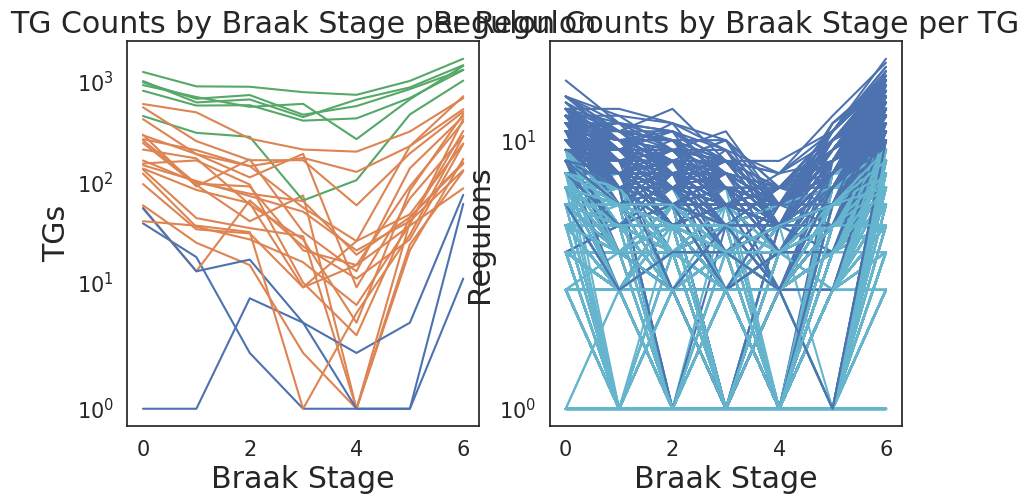

In [6]:
# Plotting
tf_counts, tg_counts = get_counts(edgelists)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axs[0])
plot_counts(tf_counts, title='TG Counts by Braak Stage per Regulon', ylabel='TGs')
plt.sca(axs[1])
plot_counts(tg_counts, title='Regulon Counts by Braak Stage per TG', ylabel='Regulons')

### Male

In [7]:
# Analysis
edgelists, bue, buer = analyze_braak(data_folder + 'grn_BRAAK_AD_', '_Sex_Male.csv')

Detecting Appearing Edges...
Braak: 0 (10400)
Braak: 1 (0)
Braak: 2 (0)
Braak: 3 (0)
Braak: 4 (8)
Braak: 5 (0)
Braak: 6 (2)

Detecting Vanishing Edges...
Braak: 0 (1)
Braak: 1 (0)
Braak: 2 (0)
Braak: 3 (20)
Braak: 4 (7)
Braak: 5 (0)
Braak: 6 (11293)

------------------------------

Appearing Edges...
Braak: 0
Top TFs:  FLI1 IKZF1 RUNX1 ZEB1 ETV6 FOXP2 TCF7L2 ETS2 MAF SOX10 TCF7L1 ERG BACH1 MXI1 SOX8 IRF8 RREB1 FOXN3 LHX6 DLX1
Top TGs:  RIN3 ZFP36L1 FLI1 NFATC2 BNC2 RREB1 FNDC3B LYN TGFBR1 MED13L UST BCAR3 TBC1D4 MYO1F PIK3CD RBM47 GNB4 DOCK8 ZFHX3 MKNK1

Braak: 4
Top TFs:  PBX3 CREM ESRRA ETV3 MSX1 TAF1 TEAD3
Top TGs:  LIX1 RHBDF1 SECISBP2 SLC22A5 SPC25 SPRYD3 USP32 ZFR

Braak: 6
Top TFs:  MEIS1 ZIC1
Top TGs:  KCTD8 ZIC4

------------------------------

Vanishing Edges...
Braak: 0
Top TFs:  LEF1
Top TGs:  IL1R1

Braak: 3
Top TFs:  CREB5
Top TGs:  ARMC1 ST3GAL4 SEMA4D SECISBP2L RHOBTB1 RAPGEF5 PLEKHA1 PLD1 PDE1A NDST1 NCOA6 IGSF8 GTDC1 FRK FNIP2 CRTC3 CDK17 C1GALT1 TMEM144 ZNF706

Braak

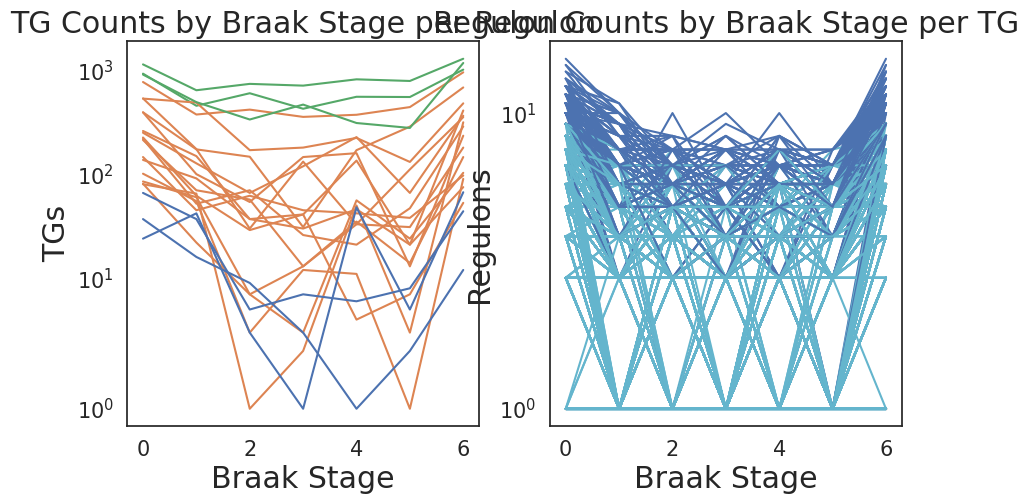

In [8]:
# Plotting
tf_counts, tg_counts = get_counts(edgelists)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axs[0])
plot_counts(tf_counts, title='TG Counts by Braak Stage per Regulon', ylabel='TGs')
plt.sca(axs[1])
plot_counts(tg_counts, title='Regulon Counts by Braak Stage per TG', ylabel='Regulons')

### Female

In [9]:
# Analysis
edgelists, bue, buer = analyze_braak(data_folder + 'grn_BRAAK_AD_', '_Sex_Female.csv')

Detecting Appearing Edges...
Braak: 0 (4567)
Braak: 1 (3)
Braak: 2 (14)
Braak: 3 (7464)
Braak: 4 (0)
Braak: 5 (0)
Braak: 6 (1)

Detecting Vanishing Edges...
Braak: 0 (0)
Braak: 1 (0)
Braak: 2 (0)
Braak: 3 (5335)
Braak: 4 (0)
Braak: 5 (0)
Braak: 6 (14298)

------------------------------

Appearing Edges...
Braak: 0
Top TFs:  FLI1 IKZF1 RUNX1 ETV6 TCF7L2 ZEB1 MAF ETS2 FOXP2 ERG BCL6 SOX10 MXI1 SOX8 ETS1 DLX1 EGR3 SOX5 LHX6 TCF7L1
Top TGs:  ZFHX3 ARHGEF6 EPAS1 RBMS1 RREB1 CHST11 FLI1 ARHGAP6 DISC1 GPCPD1 CELF2 ARHGAP24 TAB2 UBASH3B PRKCH PRKAG2 ABR UST UTRN BNC2

Braak: 1
Top TFs:  IRF1 NR3C1
Top TGs:  ATRX P2RY14 RAB11A

Braak: 2
Top TFs:  FOXN2 TFEB CEBPD ETV4 FOXO3 NFIA TCF12
Top TGs:  CARNS1 CXXC5 DHX8 DOCK5 FAS IL1RAPL1 JAG1 NPAS3 PLEKHG3 PPP2R2A RNF220 SLC24A2 SLC45A3 TCF12

Braak: 3
Top TFs:  RFX1 KLF8 CPEB1 GLIS1 KLF6 NR2F1 ANXA11 ARID3A MYEF2 NPAS2 CREB3L2 CLOCK RARA PBX3 ESRRA ESRRG ARGFX ATF3 JDP2 RFXAP
Top TGs:  SOCS2 ZIC5 DDN CDK18 UNC5B HAO2 EBF3 DPYSL5 ARHGEF2 TJAP1 GJB1 IP

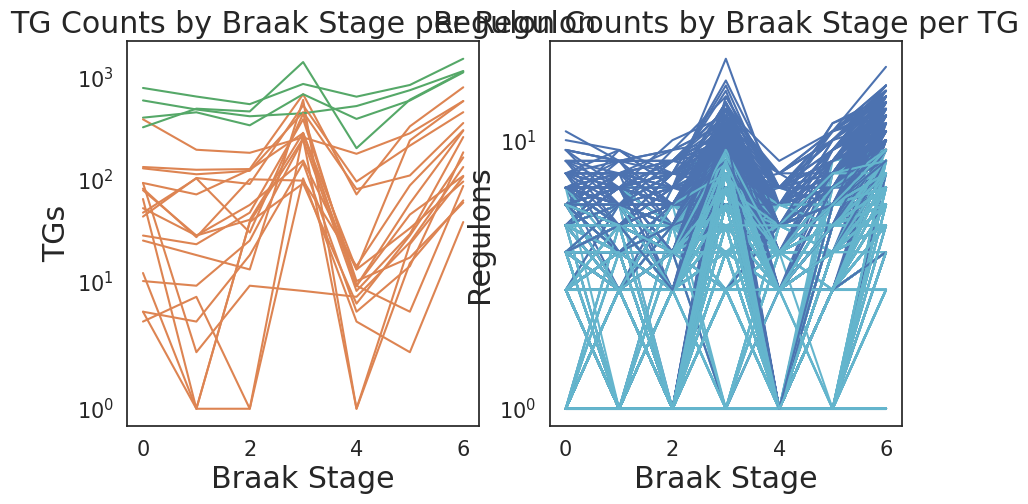

In [10]:
# Plotting
tf_counts, tg_counts = get_counts(edgelists)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axs[0])
plot_counts(tf_counts, title='TG Counts by Braak Stage per Regulon', ylabel='TGs')
plt.sca(axs[1])
plot_counts(tg_counts, title='Regulon Counts by Braak Stage per TG', ylabel='Regulons')

### EN

#### Male

In [11]:
# Analysis
edgelists, bue, buer = analyze_braak(data_folder + 'grn_EN_BRAAK_AD_', '_Sex_Male.csv')

Detecting Appearing Edges...
Braak: 0 (126)
Braak: 1 (5)
Braak: 2 (3)
Braak: 3 (0)
Braak: 4 (0)
Braak: 5 (32)
Braak: 6 (0)

Detecting Vanishing Edges...
Braak: 0 (0)
Braak: 1 (2)
Braak: 2 (1)
Braak: 3 (1)
Braak: 4 (0)
Braak: 5 (5)
Braak: 6 (161)

------------------------------

Appearing Edges...
Braak: 0
Top TFs:  ARNTL2 EGR3 ONECUT2 HLF TBR1 EGR1 ZMAT4
Top TGs:  SATB2 PART1 NPTX1 ZNF385B SH3RF2 PDP1 CUX2 SLC22A8 CDH22 FHL2 SLCO2A1 NRN1 NGEF ADAMTS16 NEUROD2 MAL2 ADAMTS3 ADCYAP1 NPY1R RBFOX3

Braak: 1
Top TFs:  CUX2 MEIS3 GLIS1
Top TGs:  CDH12 KIAA1217 OLFM3 SEC24D TCERG1L

Braak: 2
Top TFs:  BCL11A FOXP1
Top TGs:  RALYL RPH3A TBR1

Braak: 5
Top TFs:  FOXP2 RARB RFX8 ZNF831
Top TGs:  TSHZ2 ATP8B1 SLIT1 SKAP2 SEMA6D RSPO2 RORB PRKAG2 POU6F2 OSBPL3 NCK2 KCNK10 KCNH5 INPP4B TSHZ3 IL1RAPL2 HTR1F HS3ST4 GHR FSTL5

------------------------------

Vanishing Edges...
Braak: 1
Top TFs:  CUX2
Top TGs:  CDH12 KIAA1217

Braak: 2
Top TFs:  STAT4
Top TGs:  NDST3

Braak: 3
Top TFs:  EGR1
Top TGs:  E

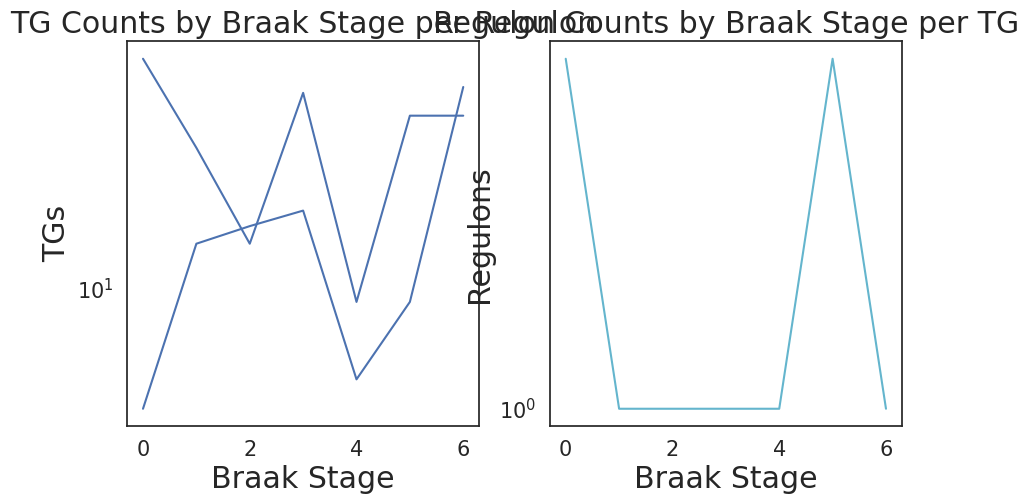

In [12]:
# Plotting
tf_counts, tg_counts = get_counts(edgelists)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axs[0])
plot_counts(tf_counts, title='TG Counts by Braak Stage per Regulon', ylabel='TGs')
plt.sca(axs[1])
plot_counts(tg_counts, title='Regulon Counts by Braak Stage per TG', ylabel='Regulons')

#### Female

In [13]:
# Analysis
edgelists, bue, buer = analyze_braak(data_folder + 'grn_EN_BRAAK_AD_', '_Sex_Female.csv')

Detecting Appearing Edges...
Braak: 0 (45)
Braak: 1 (23)
Braak: 2 (102)
Braak: 3 (143)
Braak: 4 (0)
Braak: 5 (1)
Braak: 6 (0)

Detecting Vanishing Edges...
Braak: 0 (0)
Braak: 1 (0)
Braak: 2 (66)
Braak: 3 (174)
Braak: 4 (0)
Braak: 5 (3)
Braak: 6 (214)

------------------------------

Appearing Edges...
Braak: 0
Top TFs:  ARNTL2 EGR3 GLIS1 MEIS3 ONECUT2 EGR1 EMX1 FOXP1 TBR1
Top TGs:  EPB41L4B NPTX1 NRN1 CAMK2A ADAMTS3 LRFN2 MEIS3 NEUROD6 OLFM3 ONECUT2 PTPN3 PTPRR RASGEF1A RBM24 SATB2 SLC22A25 SLC22A8 SLC30A3 SLC6A7 KCNV1

Braak: 1
Top TFs:  BCL11A HLF ZMAT4
Top TGs:  ADAMTS2 SEMA3E RPH3A RALYL PRICKLE1 PLCB4 PART1 MKX MICAL2 LNX1 ST6GALNAC5 KCNAB2 GRIA3 GFOD1 DIRAS2 DACH1 CELF4 CDH9 CDH12 CACNG3

Braak: 2
Top TFs:  ZEB1 FOXP2 POU6F2 CUX2 MEF2C RORB ELK1 NEUROD2 RARB ZNF519
Top TGs:  POU6F2 HTR1F ST6GAL2 ALK PLD5 PLCXD3 PLCB1 PLA2G4A PID1 PDZRN4 PDZRN3 PDZD2 PCDH7 OPHN1 NRXN1 NRG1 NRCAM NLGN4X NFATC2 NDST3

Braak: 3
Top TFs:  ARGFX KLF8 VAX2 HNF4A PAX2 RARA ZNF214 BRF2 TWIST1 NFIL3 TEAD4

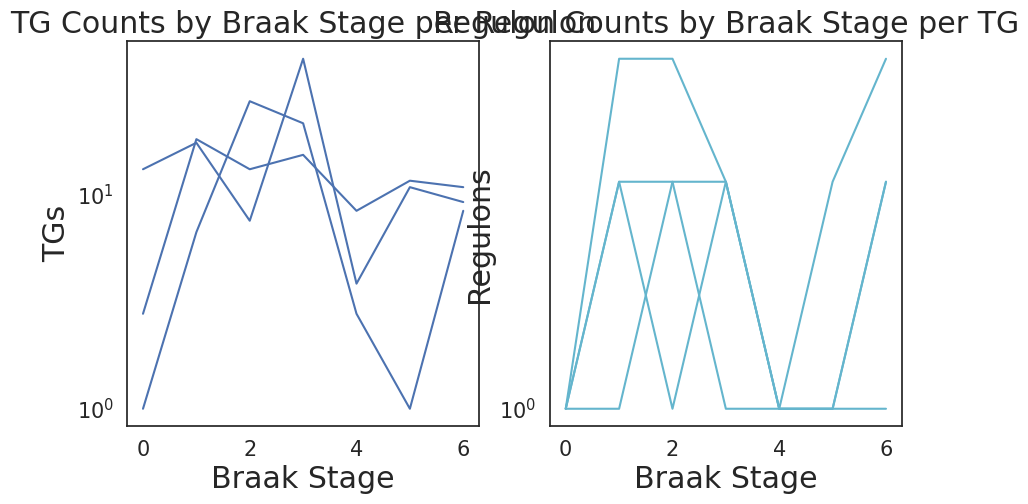

In [14]:
# Plotting
tf_counts, tg_counts = get_counts(edgelists)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axs[0])
plot_counts(tf_counts, title='TG Counts by Braak Stage per Regulon', ylabel='TGs')
plt.sca(axs[1])
plot_counts(tg_counts, title='Regulon Counts by Braak Stage per TG', ylabel='Regulons')

### IN

#### Male

In [15]:
# Analysis
edgelists, bue, buer = analyze_braak(data_folder + 'grn_IN_BRAAK_AD_', '_Sex_Male.csv')

Detecting Appearing Edges...
Braak: 0 (126)
Braak: 1 (5)
Braak: 2 (3)
Braak: 3 (0)
Braak: 4 (0)
Braak: 5 (32)
Braak: 6 (0)

Detecting Vanishing Edges...
Braak: 0 (0)
Braak: 1 (2)
Braak: 2 (1)
Braak: 3 (1)
Braak: 4 (0)
Braak: 5 (5)
Braak: 6 (161)

------------------------------

Appearing Edges...
Braak: 0
Top TFs:  ARNTL2 EGR3 ONECUT2 HLF TBR1 EGR1 ZMAT4
Top TGs:  SATB2 PART1 NPTX1 ZNF385B SH3RF2 PDP1 CUX2 SLC22A8 CDH22 FHL2 SLCO2A1 NRN1 NGEF ADAMTS16 NEUROD2 MAL2 ADAMTS3 ADCYAP1 NPY1R RBFOX3

Braak: 1
Top TFs:  CUX2 MEIS3 GLIS1
Top TGs:  CDH12 KIAA1217 OLFM3 SEC24D TCERG1L

Braak: 2
Top TFs:  BCL11A FOXP1
Top TGs:  RALYL RPH3A TBR1

Braak: 5
Top TFs:  FOXP2 RARB RFX8 ZNF831
Top TGs:  TSHZ2 ATP8B1 SLIT1 SKAP2 SEMA6D RSPO2 RORB PRKAG2 POU6F2 OSBPL3 NCK2 KCNK10 KCNH5 INPP4B TSHZ3 IL1RAPL2 HTR1F HS3ST4 GHR FSTL5

------------------------------

Vanishing Edges...
Braak: 1
Top TFs:  CUX2
Top TGs:  CDH12 KIAA1217

Braak: 2
Top TFs:  STAT4
Top TGs:  NDST3

Braak: 3
Top TFs:  EGR1
Top TGs:  E

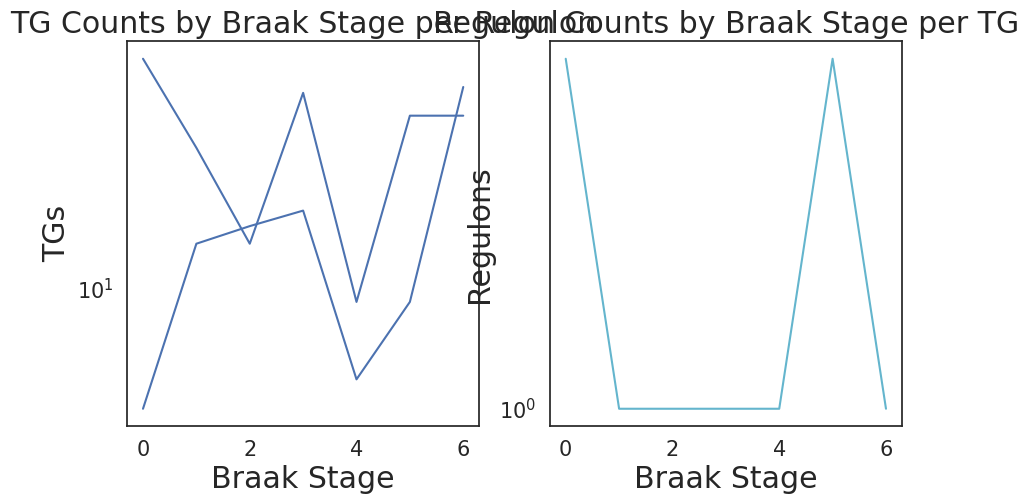

In [16]:
# Plotting
tf_counts, tg_counts = get_counts(edgelists)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axs[0])
plot_counts(tf_counts, title='TG Counts by Braak Stage per Regulon', ylabel='TGs')
plt.sca(axs[1])
plot_counts(tg_counts, title='Regulon Counts by Braak Stage per TG', ylabel='Regulons')

#### Female

In [17]:
# Analysis
edgelists, bue, buer = analyze_braak(data_folder + 'grn_IN_BRAAK_AD_', '_Sex_Female.csv')

Detecting Appearing Edges...
Braak: 0 (45)
Braak: 1 (23)
Braak: 2 (102)
Braak: 3 (143)
Braak: 4 (0)
Braak: 5 (1)
Braak: 6 (0)

Detecting Vanishing Edges...
Braak: 0 (0)
Braak: 1 (0)
Braak: 2 (66)
Braak: 3 (174)
Braak: 4 (0)
Braak: 5 (3)
Braak: 6 (214)

------------------------------

Appearing Edges...
Braak: 0
Top TFs:  ARNTL2 EGR3 GLIS1 MEIS3 ONECUT2 EGR1 EMX1 FOXP1 TBR1
Top TGs:  EPB41L4B NPTX1 NRN1 CAMK2A ADAMTS3 LRFN2 MEIS3 NEUROD6 OLFM3 ONECUT2 PTPN3 PTPRR RASGEF1A RBM24 SATB2 SLC22A25 SLC22A8 SLC30A3 SLC6A7 KCNV1

Braak: 1
Top TFs:  BCL11A HLF ZMAT4
Top TGs:  ADAMTS2 SEMA3E RPH3A RALYL PRICKLE1 PLCB4 PART1 MKX MICAL2 LNX1 ST6GALNAC5 KCNAB2 GRIA3 GFOD1 DIRAS2 DACH1 CELF4 CDH9 CDH12 CACNG3

Braak: 2
Top TFs:  ZEB1 FOXP2 POU6F2 CUX2 MEF2C RORB ELK1 NEUROD2 RARB ZNF519
Top TGs:  POU6F2 HTR1F ST6GAL2 ALK PLD5 PLCXD3 PLCB1 PLA2G4A PID1 PDZRN4 PDZRN3 PDZD2 PCDH7 OPHN1 NRXN1 NRG1 NRCAM NLGN4X NFATC2 NDST3

Braak: 3
Top TFs:  ARGFX KLF8 VAX2 HNF4A PAX2 RARA ZNF214 BRF2 TWIST1 NFIL3 TEAD4

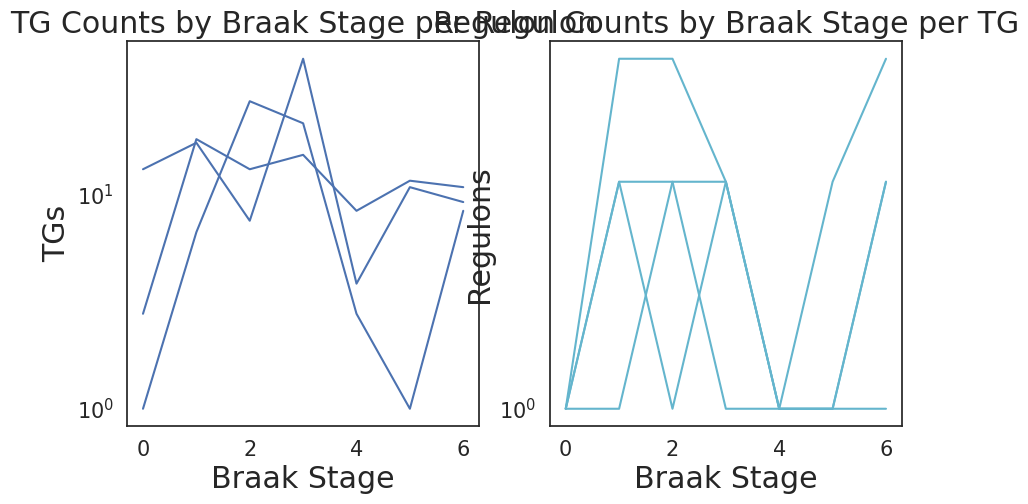

In [18]:
# Plotting
tf_counts, tg_counts = get_counts(edgelists)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axs[0])
plot_counts(tf_counts, title='TG Counts by Braak Stage per Regulon', ylabel='TGs')
plt.sca(axs[1])
plot_counts(tg_counts, title='Regulon Counts by Braak Stage per TG', ylabel='Regulons')

# Other

In [19]:
# More code